In [1]:
import gurobipy as gp
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import copy
import time

## Generazione dataset

Prima genera tutti i CC e gli SP che non appartengono a cluster, sono distribuiti uniformemente nella mappa.
Poi seleziona 10 CC che saranno il centro dei cluster, per ognuno di essi genera le coordinate degli SP (uniformemente), nella regione inclusa fra +- 3 punti di distanza. Tutti i cluster hanno stesso numero di SP

In [2]:
#la funzione prende in input: k dimensioni mappa, N_SP numero di source points, n_cluster numero di cluster 
#e cluster ratio percentuale di punti facenti parte di un cluster
#ritorna in output vettori numpy contenenti le coordinate dei punti
def data_generation(k, n_SP, n_CC, n_cluster, cluster_ratio):
    
    #definisco coordinate di tutti i CC e degli SP non facenti parte dei cluster
    P=np.random.randint(0, k+1, size=(n_CC, 2))  #genera il set dei CC
    S_no_cluster=np.random.randint(0, k+1, size=(n_SP-int(cluster_ratio*n_SP), 2))  #genera il set dei SP non facenti parte di un cluster

    #genero coordinate SP rimanenti
    cluster_index=random.sample(range(0,n_CC), int(n_CC*cluster_ratio)) #seleziona l'indice dei CC a caso che diventeranno i centri dei cluster
    S_cluster_list=[]  #creo lista vuota da popolare con i numpy array e poi concatenarli TROVA MODO PIU EFFICIENTE

    #per ognuno dei cluster genero casualmente uniformemente le coordinate (entro i 36 punti adiacenti) di 5 SP
    for i in cluster_index:
        #voglio considerare il contorno dei 36 vicini, quindi indici (i-3, j-3) (i+3, j+3)
        xmin=P[i][0]-3
        xmax=P[i][0]+3

        ymin=P[i][1]-3
        ymax=P[i][1]+3
    
        #considera ogni cluster con stesso numero di SP
        S_cluster_list.append(np.random.randint(low=[xmin, ymin], high=[xmax, ymax], size=(round(cluster_ratio*n_SP/n_cluster), 2)))

    #mette assieme il tutto
    S_cluster=np.concatenate(S_cluster_list) #crea array unico per i cluster
    S=np.concatenate((S_cluster, S_no_cluster))

    #genera posizione della fabbrica biodiesel
    biodiesel=np.random.randint(0, k+1, size=(1, 2))
    
    return P, S, biodiesel

In [3]:
#funzione che date le coordinate di due punti (in array 2d numpy) ritorna la distanza euclidea arrotondata in integer
def distance(a, b):
    dist=round(math.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2))
    return dist

In [4]:
k=1000  #dimensioni della mappa (prima test con k=1000, poi varialo per studio domansionale)

n_SP=100   #number of source points
n_CC=20 #number of collection centers
n_cluster=int(0.5*n_CC)  #number of clusters
cluster_ratio=0.5  #how many of the total nodes (SPs and CCs) fall within a cluster

#RICORDATI DI COMMENTARE IL SEED PER MISURARE PERFORMANCE
np.random.seed(seed=420) #fissa il seed per riproducibilità nei test

P, S, biodiesel=data_generation(k, n_SP, n_CC, n_cluster, cluster_ratio)


#definizione e generazione delle altre costanti
alpha=1  #costo per unità di distanza
V=5  #numero di veicoli MESSO A CASO, NEL PAPER NON TROVO QUANTO DOVREBBE ESSERE
Q=24  #numero di cestini su ogni veicolo
B=50  #capacità, in litri, dei bins sui veicoli
b=10  #costo di un bin
max_distance=300  #distanza massima fra un SP e un CC
R=1800 #lungezza massima percorso per veicolo, se distanza fra 0,0 e 1000,1000 è 1414 allora 1800 non è sufficiente nel caso il centrp biodiesel venga generato in un angolo?
P0=np.concatenate((P, biodiesel)) #set posizione biodiesel+CC (serve in calcoli veicoli)
f=np.random.randint(50, 150+1, size=(n_CC))  #costo per aprire il CC i
d_s=np.random.randint(1, 20+1, size=(len(S)))  #produzione settimanale in litri di olio del SP i
C=np.random.randint(1, 5+1, size=(n_CC))  #numero di Bins nel CC i


#P_s è il set dei CC entro la distanza di copertura dal SP s
#quindi per ogni SP creo lista P_s contente indice dei CC compatibili, poi salvo in lista di liste il tutto
P_s_list=[]  #inizializzo lista che conterrà i vari P_s
for s in range(len(S)):
    P_s=[]  #inizializzo P_s
    for i in range(len(P)): 
        if (distance(S[s], P[i])<300):   #controlla se la distanza è minore di 300
            P_s.append(i)  #se distanza e minore di 300 salva l'indice del CC compatibile
    P_s_list.append(P_s)  #aggiunge la lista alla lista totale


#crea matrice delle distanze fra elementi di P0
c0=np.empty([len(P0), len(P0)])
for i in range(len(P0)):
    for j in range(len(P0)):
        c0[i,j]=distance(P0[i], P0[j])

#crea matrice delle distanze fra elementi di S e P
cs=np.empty([len(S), len(P)])
for i in range(len(S)):
    for j in range(len(P)):
        cs[i,j]=distance(S[i], P[j])        

## Constructive heuristic

Fase 1 focus su CC location, SP assignment e bin allocation.
Fase 2 si occupa del percorso dei veicoli.

in fase 1 definisco attractiveness score per trovare set CC candidati (funzione first assignment) per poi assegnare gli SP e i bin ai CC selezionati (funzione APF).

in fase 2 si genera il percorso utilizzando algoritmo modificato di Clarke-Wright che tiene conto anche delle maximum route constraints (funzione clarke-wright).

In [5]:
#riduce il numero di possibili CC da aprire
def first_assignment(omega, n):
        P_hat=[] #set dei CC candidati
        S_to_exc=[] #indice degli SP con soluzione unica
        #prima identifico gli SP che possono essere connessi a un solo CC, che dovrà per forza essere aperto e quindi aggiunto a P_hat
        for i in range(len(P_s_list)):
            if (len(P_s_list[i])==1 and P_s_list[i][0] not in P_hat): #controlla se lista SP ha un solo CC vicino e se il CC non è già stato aggiunto a P_hat
                P_hat.append(P_s_list[i][0])
                S_to_exc.append(i)
        
        S_ch_set=set(S_set)-set(S_to_exc) #eslude SP con un unico CC vicino
        CC_ch_set=set(P_set)-set(P_hat) #esclude i CC assegnati all'SP di cui sopra

        #calcolo attractiveness
        A=np.empty(shape=(n_CC))
        #omega, n sono parametri da settare successivamente; intanto sono fissati per test

        #set dei closest CC to CC_i
        CC_closest_list=[]  #inizializzo lista che conterrà i vari set dei closest CC
        for index in range(n_CC):
            CC_closest_list.append([i[0] for i in sorted(enumerate(c0[index,:]), key=lambda x:x[1])]) #ritorna lista indici ordinati per distanza 
            #il primo elemento di ogni lista di CC_closest_list è il CC stesso, quindi va ignorato    

        #per costruire P_hat:
        while len(S_ch_set)!=0:  #finchè non vengono assegnati tutti gli SP
            for i in range(n_CC): #calcola attractiveness
                if i in P_hat:
                    A[i]=0  #per evitare di selezionare CC già in P_hat
                else:    
                    A[i]=min(C[i], sum(d_s[s] for s in S_set if i in P_s_list[s]))/(omega*c0[i,len(P0)-1]+(1-omega)*sum(c0[i][j] for j in CC_closest_list[i][1:n+1])/n)
            #seleziona attractiveness massima
            temp_max_index=max(enumerate(A[:]), key=lambda x:x[1])[0]  #trova indice e (valore massimo di A)      
            P_hat.append(temp_max_index) 
    
            #Trova gli SP vicini al CC con attractiveness massima
            S_accessible=[]
            for s in S_ch_set: 
                if temp_max_index in P_s_list[s]:
                    S_accessible.append(s)
            #calcola la capacità residua dei bin per assegnare gli SP più vicini al CC:
            C_res=B*C[temp_max_index]
            while len(S_accessible)!=0:
                #trova indice di SP più vicino    
                s_star=list(set(np.where(cs==min(cs[list(S_accessible) ,temp_max_index]))[0]).intersection(S_accessible))[0]  
                S_accessible=set(S_accessible)-set([s_star])
                if C_res>=d_s[s_star]: #controlla se SP produce meno olio della capacità residua
                    C_res=C_res-d_s[s_star]
                    S_ch_set=set(S_ch_set)-set([s_star]) #esclude SP appena assegnati
        
        
        #P_hat_s è il set dei CC entro la distanza di copertura dal SP s
        #quindi per ogni SP creo lista P_s contente indice dei CC compatibili, poi salvo in lista di liste il tutto
        P_hat_s_list=[]  #inizializzo lista che conterrà i vari P_hat_s
        for s in range(len(S)):
            P_hat_s=[]  #inizializzo P_hat_s
            for i in (P_hat): 
                if (distance(S[s], P[i])<300):   #controlla se la distanza è minore di 300
                    P_hat_s.append(i)  #se distanza e minore di 300 salva l'indice del CC compatibile
            P_hat_s_list.append(P_hat_s)  #aggiunge la lista alla lista totale
            
        return(P_hat, P_hat_s_list)  #ritorno i possibili CC da aprire e gli SP compatibili

In [6]:
#definisce il modello gurobi per assegnare gli SP
def APf(P_hat, P_hat_s_list):
        #define the AP-S (and AP-F)
        AP=gp.Model() #crea il modello

        #decision variables
        #1 se il CC i viene aperto, 0 altrimenti
        x_i=AP.addVars([(i) for i in P_hat], vtype=gp.GRB.BINARY) 

        #1 se il SP s viene assegnato al CC i, 0 altrimenti.
        z_si=AP.addVars([(s, i) for s in range(len(S)) for i in P_hat_s_list[s]], vtype=gp.GRB.BINARY) 

        #numero di bins in CC i
        y_i=AP.addVars([(i) for i in P_hat], lb=0, vtype=gp.GRB.INTEGER) 


        #objective function and constraints
        #20)objective function
        AP.setObjective(gp.quicksum(f[i]*x_i[i] for i in P_hat)+
                        b*gp.quicksum(y_i[i] for i in P_hat)
                        )

        #21)nel paper è sbagliato, z_si[s, i] i dipende da s e non esiste per tutti elementi P_hat
        #definisco allo stesso modo del constraint 2 del MIP
        AP.addConstrs(gp.quicksum(d_s[s]*z_si[s, i] for s in range(len(S)) if i in P_hat_s_list[s])<=
                      B*C[i]*x_i[i]
                      for i in P_hat 
                      )

        #22)
        AP.addConstrs(z_si[s,i]<=
                      x_i[i]
                      for s in S_set for i in P_hat_s_list[s] 
                      )    

        #23) 
        AP.addConstrs(gp.quicksum(z_si[s,i] for i in P_hat_s_list[s])==1 
                      for s in range(len(S))  
                      )   

        #24)nel paper è sbagliato, z_si[s, i] i dipende da s e non esiste per tutti elementi P_hat
        #definisco allo stesso modo del constraint 2 del MIP
        AP.addConstrs(gp.quicksum(d_s[s]*z_si[s, i] for s in range(len(S)) if i in P_hat_s_list[s])<=
                      B*y_i[i]
                      for i in P_hat 
                      )

        #constraint per passare a AP-F (AP-F forza tutti i CC trovati ad essere aperti)
        AP.addConstrs(x_i[i]==1 
                      for i in P_hat  
                      )   
        #update del modello per aggiunger la funzione obbiettivo e i constraints       
        AP.update()
        #25-27) sono gia definiti implicitamente nella inizializzazione delle decision variables    
        return AP, x_i, z_si, y_i #ritorna il modello e le variabili

In [7]:
#versione modificata di algoritmo di Clarke-Wright che tiene conto anche della durata massima del percorso.
def clarke_wright(opened_CC, number_bins):
        #per estrarre i CC aperti
        P_open=[]
        for i in P_hat:
            if (opened_CC[i]==1):
                P_open.append(P[i])
        P_open=np.concatenate([P_open]) #mette il tutto in un unico np.array

        #per estrarre il numero di bins
        bins=[]
        for i in P_hat:
            if (opened_CC[i]==1):
                bins.append(number_bins[i])
        bins=np.concatenate([bins]) #mette il tutto in un unico np.array

        #versione modificata di algoritmo Clarke-Wright savings che tiene anche conto della lunghezza massima di un percorso
        #calcola la matrice dei savings
        savings=np.empty(shape=(len(P_open),len(P_open)))
        for i in range(len(P_open)):
            for j in range(len(P_open)):
                if i==j:
                    savings[i,j]=0
                else:    
                    savings[i,j]=distance(biodiesel[0], P_open[i])+distance(biodiesel[0], P_open[j])-distance(P_open[i], P_open[j])

        #ordina in ordine decrescente i savings (considerando savings[i,j]=savings[j,i])
        links=[]
        for i in range(len(P_open)):
            for j in range(i+1, len(P_open)):
                links.append([savings[i,j], [i,j]])
        links=sorted(links, key=lambda x: x[0], reverse=True)  #ordina i savings e il link in ordine decrescente
        links=[row[1] for row in links] #ritorna solo i links del percorso

        routes = [[i] for i in range(len(P_open))]
        for i in [row[0] for row in links]:
            for j in [row[1] for row in links]:
                route_i, route_j = None, None
                #Find the routes containing CC i and j
                for route in routes: 
                    if i in route:
                        route_i = route
                    if j in route:
                        route_j = route
                    
                    #If i and j are in different routes and merging them does not violate capacity and duration constraints
                    if (route_i != None) and (route_j != None):
                        #calcola lunghezza percorso
                        totale_i=0
                        for o in range(len(P_open[route_i])-1):
                            totale_i=distance(P_open[route_i][o], P_open[route_i][o+1])
                        totale_i+=distance(P_open[route_i][0],biodiesel[0])+distance(P_open[route_i][len(route_i)-1],biodiesel[0]) #add the distance from the biodiesel facility
                    
                        totale_j=0
                        for o in range(len(P_open[route_j])-1):
                            totale_j=distance(P_open[route_j][o], P_open[route_j][o+1])
                        totale_j+=distance(P_open[route_j][0],biodiesel[0])+distance(P_open[route_j][len(route_j)-1],biodiesel[0]) #add the distance from the biodiesel facility                        
                        
                        try: #errore che non so risolvere, avviene in una sola iterazione,interromperebbe esecuzione, ma si arriva a soluzione lo stesso
                            if (route_i != route_j) and (sum(bins[route_i]) + sum(bins[route_j]) <= Q) and (totale_i+totale_j)<=1800:
                                route_i_index = routes.index(route_i)
                                route_j_index = routes.index(route_j)
                                #Merge the routes
                                routes[route_i_index] += routes[route_j_index]
                                #Remove the second route
                                routes.pop(route_j_index)
                        except: 
                            continue
        for i in range(len(routes)):
            routes[i].insert(0,len(P0)-1) #aggiunge il centro biodiesel a inizio route
            routes[i].append(len(P0)-1)  #aggiunge il centro biodiesel a fine route
        
        
        return routes #ritorna le routes sub-ottimali iniziali

In [8]:
start_initial_solution_time=time.time()
#crea i set degli indici
P_set=range(0, n_CC) #CC
S_set=range(0, n_SP) #SP
P0_set=range(0, n_CC+1)  #CC+centro biodiesel (ultimo elemento)
V_set=range(0, V)  #veicoli

#algoritmo 1
#per risparmiare tempo usa valori intermedi di n e omega invece di usarli tutti 
omega=0.1
n=math.ceil(5)
P_hat, P_hat_s_list=first_assignment(omega, n)   #Genera soluzione iniziale 
        

AP, x_i, z_si, y_i=APf(P_hat, P_hat_s_list)  #Genera il modello gurobi da ottimizzare
AP.modelSense = gp.GRB.MINIMIZE

AP.optimize()  #ottimizza il modelo gurobi
        
#accesso soluzioni
opened_CC=AP.getAttr('x', x_i)
connected_SP=AP.getAttr('x', z_si)
number_bins=AP.getAttr('x', y_i)

#usa le soluzioni appena trovate per costruire delle routes sub-ottimali 
route=clarke_wright(opened_CC, number_bins)
#Gli indici della route in beta corrispondon a ordine degli opened_CC in beta, in VNS bisogna convertirli a indici di P/P0    
#per estrarre i CC aperti
P_open=[]
for i in opened_CC.keys():
    if (opened_CC[i]==1):
        P_open.append(i)

#per convertire gli elementi delle route a indici del CC
for i in range(len(route)): #seleziona route
    for j in range(1, len(route[i])-1): #cambia gli indici interni, estremi corrispondono già al depot
        route[i][j]=P_open[route[i][j]]

#aggiunge a lista i risultati trovati per i valori correnti di omega e n
AP.dispose()   #resetta il modello
final_initial_solution_time=time.time()-start_initial_solution_time

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-26
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: AMD Ryzen 3 3250U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 544 rows, 428 columns and 2028 nonzeros
Model fingerprint: 0xae53c39a
Variable types: 0 continuous, 428 integer (412 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1945.0000000
Presolve removed 431 rows and 32 columns
Presolve time: 0.00s
Presolved: 113 rows, 396 columns, 1068 nonzeros
Variable types: 0 continuous, 396 integer (377 binary)

Root relaxation: objective 1.864400e+03, 139 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl

In [9]:
route  #starting solution for the route

[[20, 7, 1, 20],
 [20, 18, 2, 20],
 [20, 10, 5, 20],
 [20, 17, 20],
 [20, 14, 11, 9, 19, 15, 20],
 [20, 3, 20],
 [20, 13, 20],
 [20, 4, 20],
 [20, 8, 20]]

## VNS

Implementazione di una variable neighborhood search utilizzando le soluzioni appena trovate con constructive heuristic.

La VNS utilizza quattro diverse operazioni:

-)inserisce un segmento di una route in un altra route (insert)

-)scambia segementi di due route(swap)

-)rimuove un segmento di CCs da una route e aggiunge un numero di CCs non aperti alla route (insert & remove)

-)rimuove un CC dalla route (Remove)

Remove funziona su massimo 1 CC alla volta, remove_add fino a 2 CC per volta, insert e swap fino a 3 per volta

In [10]:
#sposta un segmento di lunghezza 1 in altra route
def insertion1(vehicle_route_to_be_copied):
    #per simulare passaggio funzione by value
    vehicle_route=copy.deepcopy(vehicle_route_to_be_copied)
    i,j=random.sample(range(len(vehicle_route)),2) #seleziona due route a caso 
    k=random.sample(range(1, len(vehicle_route[i])-1),1)[0] #seleziona segmento route1 a caso
    l=random.sample(range(1, len(vehicle_route[j])-1),1)[0] #seleziona segmento route2 a caso
    vehicle_route[i].insert(k, #posizione in cui inserire segmento
                            vehicle_route[j][l]  #segmento da inserire
                            ) 
    vehicle_route[j].pop(l) #elimina il segmento spostato dalla route
    if (len(vehicle_route[j])==2): #elimina la route se non ci sono più CC
        vehicle_route.pop(j)
    return vehicle_route

#sposta un segmento di lunghezza 2 (se esistente altrimenti lunghezza 1) in altra route
def insertion2(vehicle_route_to_be_copied):
    #per simulare passaggio funzione by value
    vehicle_route=copy.deepcopy(vehicle_route_to_be_copied)    
    i,j=random.sample(range(len(vehicle_route)),2) #seleziona due route a caso 
    
    #route i in cui inserisco può avere qualsiasi lunghezza 
    #il segmento di route j avrà lunghezza min(len(vehicle_route)-2,2) cioè 1 se route visita solo un CC 
    k=random.sample(range(1, len(vehicle_route[i])-1),1)[0] #seleziona segmento route1 a caso per sapere dove inserire
    
    seg_length=min(len(vehicle_route[j])-2,2)
    for seg in range(seg_length):  #seleziona a caso, uno per volta i  CC.
        l=random.sample(range(1, len(vehicle_route[j])-1),1)[0] #seleziona segmento route2 a caso
        
        vehicle_route[i].insert(k, #posizione in cui inserire segmento
                                vehicle_route[j][l]  #segmento da inserire
                                ) 
       
        vehicle_route[j].pop(l) #elimina il segmento spostato dalla route           
    
    if (len(vehicle_route[j])==2): #elimina la route se non ci sono più CC
        vehicle_route.pop(j)
    return vehicle_route

#sposta un segmento di lunghezza 3 (se esistente altrimenti lunghezza 1 o 2) in altra route
def insertion3(vehicle_route_to_be_copied):
    #per simulare passaggio funzione by value
    vehicle_route=copy.deepcopy(vehicle_route_to_be_copied)    
    i,j=random.sample(range(len(vehicle_route)),2) #seleziona due route a caso 

    k=random.sample(range(1, len(vehicle_route[i])-1),1)[0] #seleziona segmento route1 a caso per sapere dove inserire
    
    seg_length=min(len(vehicle_route[j])-2,3)
    #con questa implementazione i segmenti selezionati non è detto siano conseguenti, potrebbe essere un problema?
    for seg in range(seg_length):  #seleziona a caso, uno per volta i  CC.
        l=random.sample(range(1, len(vehicle_route[j])-1),1)[0] #seleziona segmento route2 a caso
        
        vehicle_route[i].insert(k, #posizione in cui inserire segmento
                                vehicle_route[j][l]  #segmento da inserire
                                ) 
       
        vehicle_route[j].pop(l) #elimina il segmento spostato dalla route        
    
    if (len(vehicle_route[j])==2): #elimina la route se non ci sono più CC
        vehicle_route.pop(j)
    return vehicle_route
        
#scambia segmento di lunghezza 1 fra due route
def swap1(vehicle_route_to_be_copied):
    vehicle_route=copy.deepcopy(vehicle_route_to_be_copied) #per simulare passaggio funzione by value
    i,j=random.sample(range(len(vehicle_route)),2) #seleziona due route a caso 
    k=random.sample(range(1, len(vehicle_route[i])-1),1)[0] #seleziona segmento route1 a caso
    l=random.sample(range(1, len(vehicle_route[j])-1),1)[0] #seleziona segmento route2 a caso

    vehicle_route[i][k], vehicle_route[j][l]= vehicle_route[j][l], vehicle_route[i][k] #scambia i segmenti
    return vehicle_route
    
#scambia segmento di lunghezza 2 fra due route
def swap2(vehicle_route_to_be_copied):
    vehicle_route=copy.deepcopy(vehicle_route_to_be_copied) #per simulare passaggio funzione by value
    i,j=random.sample(range(len(vehicle_route)),2) #seleziona due route a caso 
    k=random.sample(range(1, len(vehicle_route[i])-1),1)[0] #seleziona segmento route1 a caso
    l=random.sample(range(1, len(vehicle_route[j])-1),1)[0] #seleziona segmento route2 a caso
    
    seg_length=min(len(vehicle_route[i])-2, len(vehicle_route[j])-2,2) 
    for seg in range(seg_length):  #seleziona a caso, uno per volta i  CC.
        k=random.sample(range(1, len(vehicle_route[i])-1),1)[0] #seleziona segmento route1 a caso
        l=random.sample(range(1, len(vehicle_route[j])-1),1)[0] #seleziona segmento route2 a caso

        vehicle_route[i][k], vehicle_route[j][l]= vehicle_route[j][l], vehicle_route[i][k] #scambia i segmenti
    return vehicle_route

#scambia segmento di lunghezza 3 fra due route
def swap3(vehicle_route_to_be_copied):
    vehicle_route=copy.deepcopy(vehicle_route_to_be_copied) #per simulare passaggio funzione by value
    i,j=random.sample(range(len(vehicle_route)),2) #seleziona due route a caso 
    k=random.sample(range(1, len(vehicle_route[i])-1),1)[0] #seleziona segmento route1 a caso
    l=random.sample(range(1, len(vehicle_route[j])-1),1)[0] #seleziona segmento route2 a caso
    
    seg_length=min(len(vehicle_route[i])-2, len(vehicle_route[j])-2,3) 
    for seg in range(seg_length):  #seleziona a caso, uno per volta i  CC.
        k=random.sample(range(1, len(vehicle_route[i])-1),1)[0] #seleziona segmento route1 a caso
        l=random.sample(range(1, len(vehicle_route[j])-1),1)[0] #seleziona segmento route2 a caso

        vehicle_route[i][k], vehicle_route[j][l]= vehicle_route[j][l], vehicle_route[i][k] #scambia i segmenti
    return vehicle_route        
    
#rimuove 1 CC dalla route e aggiunge un CC chiuso a route 
def remove_add1(vehicle_route_to_be_copied):
    vehicle_route=copy.deepcopy(vehicle_route_to_be_copied) #per simulare passaggio funzione by value
    global P_open #per usare variabile globale della lista dei CC aperti
    i=random.sample(range(len(vehicle_route)),1)[0] #seleziona route a caso 
    k=random.sample(range(1, len(vehicle_route[i])-1),1)[0] #seleziona segmento route1 a caso
    
    #messe in quest'ordine il segmento appena tolto può essere scelto nuovamente, ma altrimenti programma non funziona quando tutti i CC sono aperti     n=random.sample(list(set(P_set)-set(P_open)), 1)[0] #sceglie CC non ancora aperto 
    P_open=list(set(P_open)-set([vehicle_route[i][k]])) #rimuove il segmento dai CC aperti
    vehicle_route[i].pop(k) #elimina il segmento di CCs dalla route

    n=random.sample(list(set(P_set)-set(P_open)), 1)[0] #sceglie a caso un CC non aperto
    P_open.append(n) #aggiunge il CC scelto a lista CC aperti
    vehicle_route[i].insert(k, #sposizione in cui inserire segmento
                            n  #segmento da inserire
                            ) 
    return vehicle_route

#rimuove 2 CC (se possibile, altrimenti 1) dalla route e aggiunge un CC chiuso a route 
def remove_add2(vehicle_route_to_be_copied):
    vehicle_route=copy.deepcopy(vehicle_route_to_be_copied) #per simulare passaggio funzione by value
    global P_open #per usare variabile globale della lista dei CC aperti
    i=random.sample(range(len(vehicle_route)),1)[0] #seleziona route a caso 
    
    seg_length=min(len(vehicle_route[i])-2, 2) 
    for seg in range(seg_length):  #seleziona a caso, uno per volta i  CC.
        k=random.sample(range(1, len(vehicle_route[i])-1),1)[0] #seleziona segmento route1 a caso

        P_open=list(set(P_open)-set([vehicle_route[i][k]])) #rimuove il segmento dai CC aperti
        vehicle_route[i].pop(k) #elimina il segmento di CCs dalla route

    n=random.sample(list(set(P_set)-set(P_open)), 1)[0] #sceglie a caso un CC non aperto
    P_open.append(n) #aggiunge il CC scelto a lista CC aperti
    vehicle_route[i].insert(k, #sposizione in cui inserire segmento
                            n  #segmento da inserire
                            ) 
    return vehicle_route

#rimuove 2 CC (se possibile, altrimenti 1) dalla route e aggiunge 2 CC chiusi (se possibile, altrimenti 1) a route 
def remove_add3(vehicle_route_to_be_copied):
    vehicle_route=copy.deepcopy(vehicle_route_to_be_copied) #per simulare passaggio funzione by value
    global P_open #per usare variabile globale della lista dei CC aperti
    i=random.sample(range(len(vehicle_route)),1)[0] #seleziona route a caso 
    
    seg_length=min(len(vehicle_route[i])-2, 2) 
    for seg in range(seg_length):  #seleziona a caso, uno per volta i  CC.
        k=random.sample(range(1, len(vehicle_route[i])-1),1)[0] #seleziona segmento route1 a caso

        P_open=list(set(P_open)-set([vehicle_route[i][k]])) #rimuove il segmento dai CC aperti
        vehicle_route[i].pop(k) #elimina il segmento di CCs dalla route

    add_length=min(len(list(set(P_set)-set(P_open))), 2)
    for CC in range(add_length):
        n=random.sample(list(set(P_set)-set(P_open)), 1)[0] #sceglie a caso un CC non aperto
        P_open.append(n) #aggiunge il CC scelto a lista CC aperti
        vehicle_route[i].insert(k, #sposizione in cui inserire segmento
                                n  #segmento da inserire
                               ) 
    return vehicle_route


#rimuove un CC da una route
def remove(vehicle_route_to_be_copied):
    vehicle_route=copy.deepcopy(vehicle_route_to_be_copied) #per simulare passaggio funzione by value
    global P_open #per usare variabile globale della lista dei CC aperti
    i=random.sample(range(len(vehicle_route)),1)[0] #seleziona route a caso 
    k=random.sample(range(1, len(vehicle_route[i])-1),1)[0] #seleziona segmento route1 a caso
    P_open=list(set(P_open)-set([vehicle_route[i][k]])) #rimuove il segmento dai CC aperti

    vehicle_route[i].pop(k) #elimina il segmento di CCs
    if (len(vehicle_route[i])==2): #elimina la route se non ci sono più CC
        vehicle_route.pop(i)
    return vehicle_route    


#calcolo della funzione obbiettivo
def objective(P_open, vehicle_route, number_bins):
    #calcola il costo totale delle route (costo per unità di distanza è alpha)
    route_cost=0
    for i in range(len(vehicle_route)):
        for j in range(len(vehicle_route[i])-1):
            route_cost+=distance(P0[vehicle_route[i][j]],P0[vehicle_route[i][j+1]])

    #calcola il costo di aprire le route        
    opening_cost=0
    for i in P_open:
        opening_cost+=f[i]

    #calcola il costo dei bin    
    bin_cost=0
    for i in P_open:
        try:  #da errore quando il numero di bins non esiste, dato che se non esiste sarebbe zero costo non aumenta quindi non cambia usando try/except
            bin_cost+=b*number_bins[i]
        except:
            continue
    return route_cost+opening_cost+bin_cost

In [11]:
%%capture message
#per non scrivere output (sarebbe troppo lungo per via dell'output di gurobi)

theta=[insertion1, insertion2, insertion3, swap1, swap2, swap3, remove_add1, remove_add2, remove_add3, remove] #definisce la neighborhood
t_max=10800 #tempo massimo da spendere in una neighborhood (60 per test poi aumenta anche a ore)
r=0.1
t_tot=0  
counter_inner=0
counter_outer=0
start=time.time()
initial_route=copy.deepcopy(route) #copia la route iniziale per non modificarla
#termina dopo 10800 secondi o dopo che non viene migliorata la soluzione per 10000 volte di fila o dopo 10000 volte di fila che non si esce dal minimo locale
#altrimenti termina automaticamente quando non ci sono più operazioni possibili (i.e non ci sono abbastanza CC rimasti)
while (t_tot<t_max and counter_inner<10000 and counter_outer<10000): 
    for op in theta:
        initial_P_open=copy.deepcopy(P_open) #salva la sol iniziale per non modificarla se non migliorerebbe
        obbiettivo1=objective(P_open, initial_route, number_bins)  #calcola funzione obbiettivo
        new_route=op(initial_route)  #applica operazione nuovo percorso
        new_obbiettivo=objective(P_open, new_route, number_bins) #stima nuova funzione obbiettivo
        if (new_obbiettivo<=(1+r)*obbiettivo1):  #se si scappa dal minimo locale
            counter_outer=0 #azzera il contatora dei fallimenti uscita dal minimo
            #salta righe 9-15 per controllo su feasibility di AP-F, passa direttamente a local search
            #ora bisogna solvere l'AP-F per modificare i CC aperti e SP connessi
            P_hat=copy.deepcopy(P_open)
            #P_hat_s è il set dei CC entro la distanza di copertura dal SP s
            #quindi per ogni SP creo lista P_s contente indice dei CC compatibili, poi salvo in lista di liste il tutto
            P_hat_s_list=[]  #inizializzo lista che conterrà i vari P_hat_s
            for s in range(len(S)):
                P_hat_s=[]  #inizializzo P_hat_s
                for i in (P_hat): 
                    if (distance(S[s], P[i])<300):   #controlla se la distanza è minore di 300
                        P_hat_s.append(i)  #se distanza e minore di 300 salva l'indice del CC compatibile
                P_hat_s_list.append(P_hat_s)  #aggiunge la lista alla lista totale

            AP, x_i, z_si, y_i=APf(P_hat, P_hat_s_list)  #Genera il modello gurobi da ottimizzare
            AP.modelSense = gp.GRB.MINIMIZE
            AP.setParam('TimeLimit', 60)  #set tempo massimo ricerca soluzione
            AP.optimize()  #ottimizza il modelo gurobi
        
            #accesso soluzioni
            try: #controlla se il modello è risolubile, se è infeasible passa a iterazione successiva
                opened_CC_new=AP.getAttr('x', x_i) 
            except:
                P_open=copy.deepcopy(initial_P_open) #non aggiorna P_open se fallisce
                counter_inner+=1 #aumenta il counter se non viene aggiornata la route
                continue
            
            connected_SP_new=AP.getAttr('x', z_si)
            number_bins_new=AP.getAttr('x', y_i)
            AP.dispose() #resetta il modello gurobi
            P_open=[] #aggiorna P_open con appena trovati
            for i in opened_CC_new.keys():
                if (opened_CC_new[i]==1):
                    P_open.append([i][0])
                    
            #local search applicando insertion e swap
            final_route=swap1(new_route)
            final_route=insertion1(final_route)

            #bisogna controllare route constraints per ogni route
            check=[]
            for i in range(len(final_route)):
                totale_cost=0 #costo strada
                totale_bins=0 #capacità bins
                for o in range(len(final_route[i])-1): #calcolo costo strada
                    totale_cost+=distance(P0[final_route[i][o]], P0[final_route[i][o+1]])
                for o in final_route[i][1:len(final_route[i])-1]: #calcolo bins totali (esclude i depot)   
                    totale_bins+=number_bins_new[o]
                check.append(totale_cost<1800 and totale_bins<Q) #True solo se entrambi i constraint sono soddisfatti, PER CASI CON n_CC più alti aumenta max route length da 1800 a 3600
  
            #calcola nuova funzione obbiettivo, e controlla se è minore di vecchia e controlla se constraint soddisfatti:
            if (objective(P_open, final_route, number_bins_new)<=obbiettivo1 and all(check)==True):
                #se nuova funzione è migliore, aggiorna soluzione
                opened_CC=copy.deepcopy(opened_CC_new)
                connected_SP=copy.deepcopy(connected_SP_new)
                number_bins=copy.deepcopy(number_bins_new)
                initial_route=copy.deepcopy(final_route)
                saved_route=copy.deepcopy(final_route) #variabile extra in cui salvare la route che verrà usata come sol finale
                counter_inner=0
                break #start again from first operation
            else:
                P_open=copy.deepcopy(initial_P_open) #non aggiorna P_open se fallisce
                counter_inner+=1 #aumenta il counter se non viene aggiornata la route
        else: #se non si esce dal minimo non modificare la route
            P_open=copy.deepcopy(initial_P_open) #non aggiorna P_open se fallisce           
            counter_outer+=1
    
    t_tot=time.time()-start   

ValueError: Sample larger than population or is negative

In [12]:
saved_route

[[20, 6, 15, 7, 18, 20], [20, 13, 8, 5, 20]]

In [13]:
print(f'per costruire sol iniziale: {final_initial_solution_time} per costruire sol finale: {t_tot}')

per costruire sol iniziale: 3.0747761726379395 per costruire sol finale: 147.38765740394592


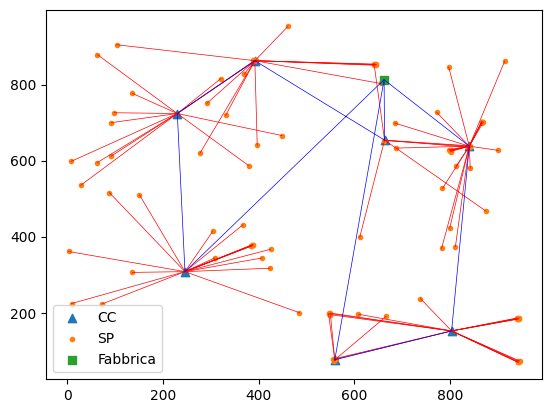

In [14]:
#per estrarre i CC aperti
P_open=[]
for i in opened_CC.keys():
    if (opened_CC[i]==1):
        P_open.append(P[i])
P_open=np.concatenate([P_open]) #mette il tutto in un unico np.array

#per estrarre le coppie CC-SP
CC_SP=[]
for s,i in connected_SP.keys():
    if (connected_SP[s,i]==1):
        CC_SP.append(([S[s]],[P[i]]))
#mette il tutto in due array            
SP_coord=np.concatenate([i[0] for i in CC_SP])
CC_coord=np.concatenate([i[1] for i in CC_SP])


#plot
plt.scatter(P_open[:,0], P_open[:,1], label="CC", marker="^")
plt.scatter(S[:,0], S[:,1], label="SP", marker=".")
plt.scatter(biodiesel[:,0], biodiesel[:,1], label="Fabbrica", marker=",")
plt.plot([SP_coord[:,0], CC_coord[:,0]], [SP_coord[:,1], CC_coord[:,1]], color='red', linewidth=0.5)#plotta collegamenti fra CC e SP
for i in range(len(saved_route)):
    plt.plot(P0[saved_route[i]][:,0], P0[saved_route[i]][:,1], linewidth=0.5, color='blue')#plotta le route

plt.legend()
plt.show()